In [1]:
import matplotlib.pyplot as plt
import sscPhantom
import numpy as np
from sscRadon import radon
import matplotlib.pyplot as plt

/home/ABTLUS/yuri.tonin/.local/lib/python3.6/site-packages/pkg_resources/__init__.py:119: PkgResourcesDeprecationWarning: 1.0.0. is an invalid version and will not be supported in a future release
  PkgResourcesDeprecationWarning,


## Define complex phantom

mario: (64, 64, 64) 524.3KB
-15.707963267948966 15.707963267948966
-3.1415926535897927 3.1415926535897927


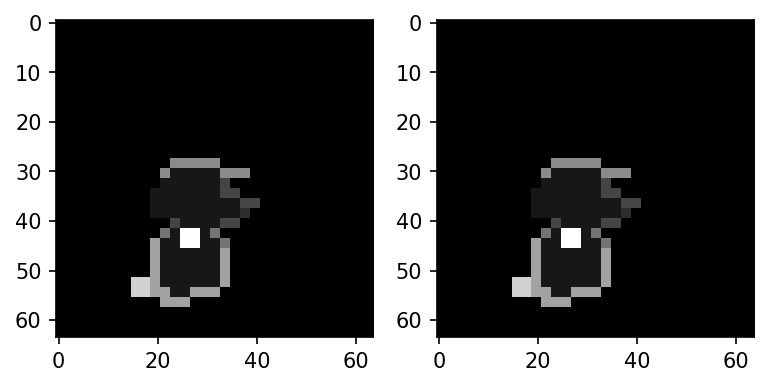

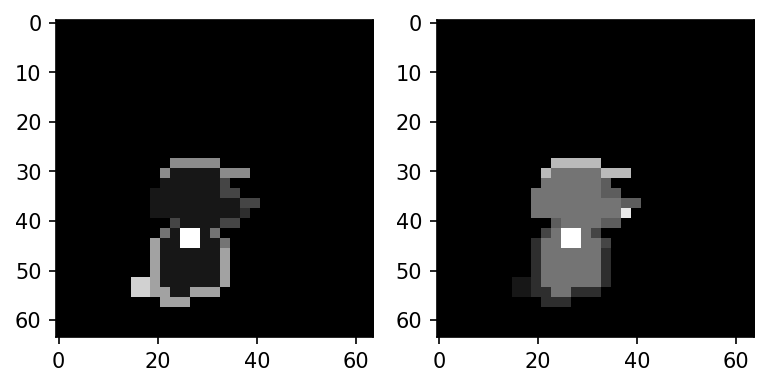

In [2]:
N = 64
Z=0.5
noise = False
unwrap = False

path_tomo = "/ibira/lnls/beamlines/caterete/apps/jupyter/00000000/proc/recons/phantom_complex/object_phantom_complex.npy"
path_phantom = "/ibira/lnls/beamlines/caterete/apps/jupyter/00000000/proc/recons/phantom_complex/phantom_complex.npy"

mario = sscPhantom.mario.createMario(shape=N, noise=noise, zoom=Z)
phase = 2*np.pi*mario/mario.max() - np.pi
phase = 5*phase

print(np.min(phase),np.max(phase))

if unwrap == True:
    phase = 20*phase
    gradient = np.ones_like(phase)
    values = np.linspace(0,1,phase.shape[0])*2*np.pi
    for i in range(phase.shape[0]):
        gradient[i,:,:] = gradient[i,:,:]*values[i]
        gradient[:,i,:] = gradient[:,i,:]*values[i]
    phase = phase + gradient 
    
# phase = np.flip(phase,axis=1)
phase = np.roll(phase,-6,axis=1)
phase = np.roll(phase,9,axis=0)

magnitude = mario/mario.max() + 1
magnitude = np.roll(magnitude,-6,axis=1)
magnitude = np.roll(magnitude,9,axis=0)

phantom = magnitude*np.exp(1j*phase)

figure, ax = plt.subplots(1,2,dpi=150)
ax[0].imshow(magnitude[:,:,phantom.shape[0]//2],cmap='gray')
ax[1].imshow(phase[:,:,phantom.shape[0]//2],cmap='gray')

magnitude = np.abs(phantom)
phase = np.angle(phantom)
print(np.min(phase),np.max(phase))

figure, ax = plt.subplots(1,2,dpi=150)
ax[0].imshow(magnitude[:,:,phantom.shape[0]//2],cmap='gray')
ax[1].imshow(phase[:,:,phantom.shape[0]//2],cmap='gray')

np.save(path_phantom,phantom)

## Get phantom projections

-3.1415926535897927 3.1415926535897927
0.0 6.283185307179585
-3.1415927 3.1415927
-2.8607376 3.1415925


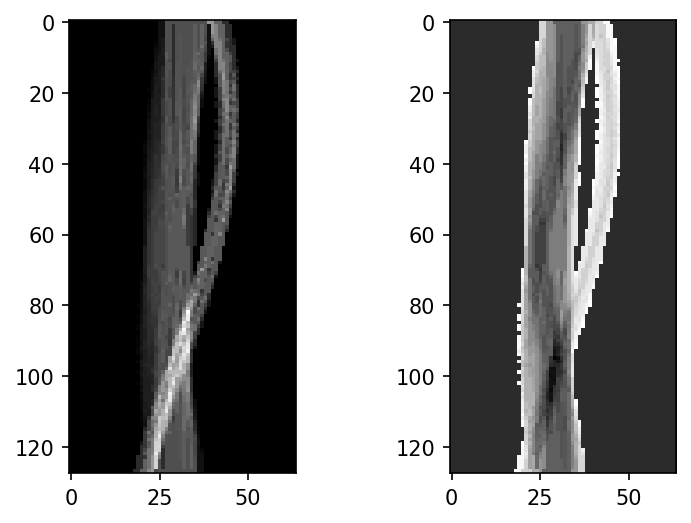

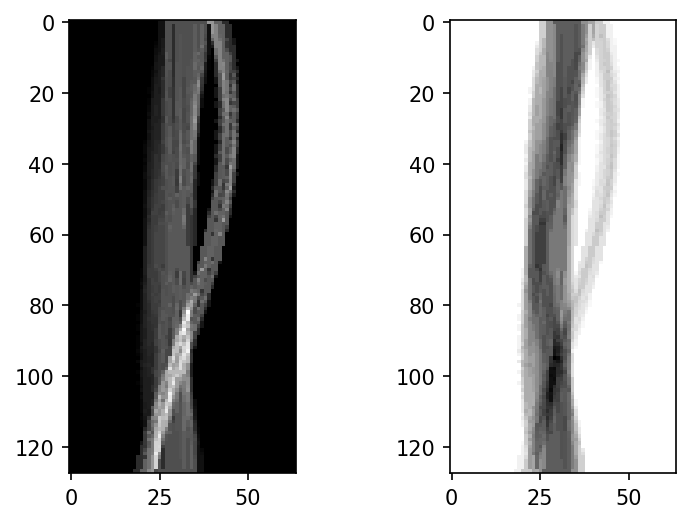

In [3]:
gpus    = [5]
nangles = 2*N
magnitude = np.abs(phantom) - 1
phase = np.angle(phantom)
print(np.min(phase),np.max(phase))

minimum = np.min(phase)
phase = phase - minimum
print(np.min(phase),np.max(phase))

tomogram_magnitude = np.swapaxes( radon.radon_gpu_block( magnitude, nangles, gpus, blocksize=10 ), 0, 1)
tomogram_phase     = np.swapaxes( radon.radon_gpu_block( phase, nangles, gpus, blocksize=10 ), 0, 1)

tomogram_phase = 2*np.pi*tomogram_phase/np.max(tomogram_phase) - np.pi
tomogram_phase = -tomogram_phase
print(np.min(tomogram_phase),np.max(tomogram_phase))


# noise = np.random.normal(0, phantom.max()/100, tomogram_magnitude.shape)
# tomogram_magnitude = tomogram_magnitude + 1 * noise

# noise = np.random.normal(0, phantom.max()/100, tomogram_phase.shape)
# tomogram_phase = tomogram_phase + 1 * noise

tomogram = tomogram_magnitude*np.exp(1j*tomogram_phase)
print(np.min(np.angle(tomogram)),np.max(np.angle(tomogram)))

figure, ax = plt.subplots(1,2,dpi=150)
ax[0].imshow(np.abs(tomogram[:,tomogram.shape[1]//2,:]),cmap='gray')
ax[1].imshow(np.angle(tomogram[:,tomogram.shape[1]//2,:]),cmap='gray')

figure, ax = plt.subplots(1,2,dpi=150)
ax[0].imshow(tomogram_magnitude[:,tomogram.shape[1]//2,:],cmap='gray')
ax[1].imshow(tomogram_phase[:,tomogram.shape[1]//2,:],cmap='gray')

np.save(path_tomo,tomogram)

In [4]:
# path = "/ibira/lnls/beamlines/caterete/apps/jupyter/00000000/data/ptycho3d/phantom_complex/positions"

# angles = np.linspace(-90,90,tomogram.shape[0])*np.pi/180

# for i, angle_number in enumerate(range(tomogram.shape[0])): 
#     filename = str(angle_number).zfill(4)+f"_phantom_complex_001.txt"
#     line = f"Ry: {angles[i]}\tPiezoB2\tPiezoB3\tPiezoB1\t"
#     print(line)
#     with open(os.path.join(path,filename), 'w') as f:
#         f.write(line)

In [5]:
# Get 3D sample
    # Create magnitude
    # Create phase
# Apply Radon
    # Get tomogram angles
    # Get frames
# Loop
    # Get probe
    # Get tomogram frame
    # Get positions
    # Save positions file
    # Loop:
        # Get output wave for each position
        # FT and intensity
        # Optional: 
            # Apply mask
            # Apply flat
            # Apply empty
            # Apply dbeam
        # Populate dataset
    # Save hdf5

import numpy as np
import h5py

def propagate(wavefront):
    from numpy.fft import fft2, fftshift, ifftshift, ifft2
    output = fftshift(fft2(fftshift(wavefront)))
    return output

def get_diffraction_pattern(output_wave):
    return np.abs(propagate(output_wave))**2
    
def create_hdf(path,data):
    hf = h5py.File(path, 'w')
    g2 = hf.create_group('entry/data')
    g2.create_dataset('data', data=data)
    hf.close()

d1 = np.ones((100,1,100,100),dtype='int32')



create_hdf('/ibira/lnls/beamlines/caterete/apps/jupyter/00000000/data/ptycho3d/phantom_complex/scans/data.hdf5',d1)
    

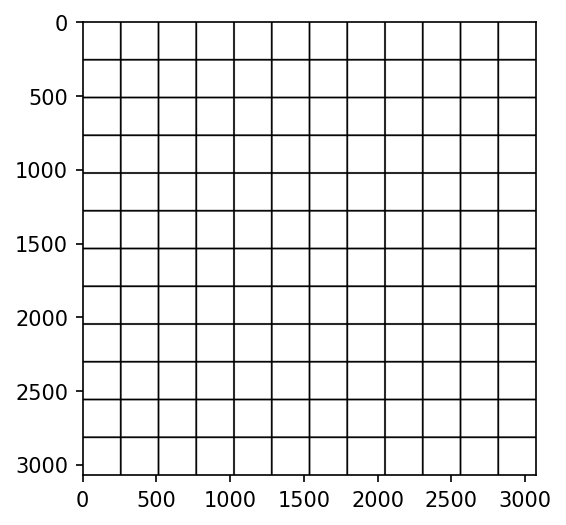

In [6]:
def get_invalid_gridpoints(shape=(3072,3072),chipsize=256,delta=6):
    invalid_grid = np.ones(shape)
    for position in range(chipsize,invalid_grid.shape[0],chipsize):
        invalid_grid[position-delta:position+delta,:] = 0
        invalid_grid[:,position-delta:position+delta] = 0
    return invalid_grid

shape = (3072,3072)

invalid_grid = get_invalid_gridpoints()

# threshold = 0.9
# invalid_points = np.random.rand(*shape)
# invalid_points = np.where(invalid_points>threshold,0,1)
invalid_points = np.ones(shape)

noise = np.random.normal(scale=10,size=shape)
noise -= np.min(noise)
bad_mask = invalid_grid*invalid_points #+ noise

import matplotlib.pyplot as plt    
plt.figure(dpi=150)
plt.imshow(bad_mask,cmap='gray')

In [7]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import data, img_as_float, color, exposure
from skimage.restoration import unwrap_phase
import sscPhantom

N=256

# img = sscPhantom.mario.createMario(shape=N, noise=False, zoom=0.5)

params = { 'HowMany': 10,
           'radius': 0.07,
           'Rtorus': 0.5,
           'rtorus': 0.1}

nproc  = 16
energy = 7  #Kev
phantom1, phantom2 = sscPhantom.donuts.createDonuts( 64, nproc, energy, params )
phantom = phantom1 + phantom2
img = phantom[:,phantom.shape[1]//2,:]




--> ssc-phantom: particles generated / elapsed: 40.96659207344055
sscPhantom: creating 2 64x64x64 shared arrays (Phantom)
Done: 64 images within 0.20067644119262695 sec
--> ssc-phantom: donuts created / elapsed: 0.2009589672088623


In [8]:
import sscCdi

/home/ABTLUS/yuri.tonin/.local/lib/python3.6/site-packages/sscCdi
to be done!
/home/ABTLUS/yuri.tonin/.local/lib/python3.6/site-packages/sscRaft/lib/libraft.cpython-36m-powerpc64le-linux-gnu.so


Real 0.3 1.1 -1
Fitted -0.00044109980237669604 -0.0014825540548494417 0.05160303747390885
Fitted 0.3006506423790723 1.0986951795211817 -1.2565735701647611


Text(0.5, 1.0, 'Unwrapped minus original')

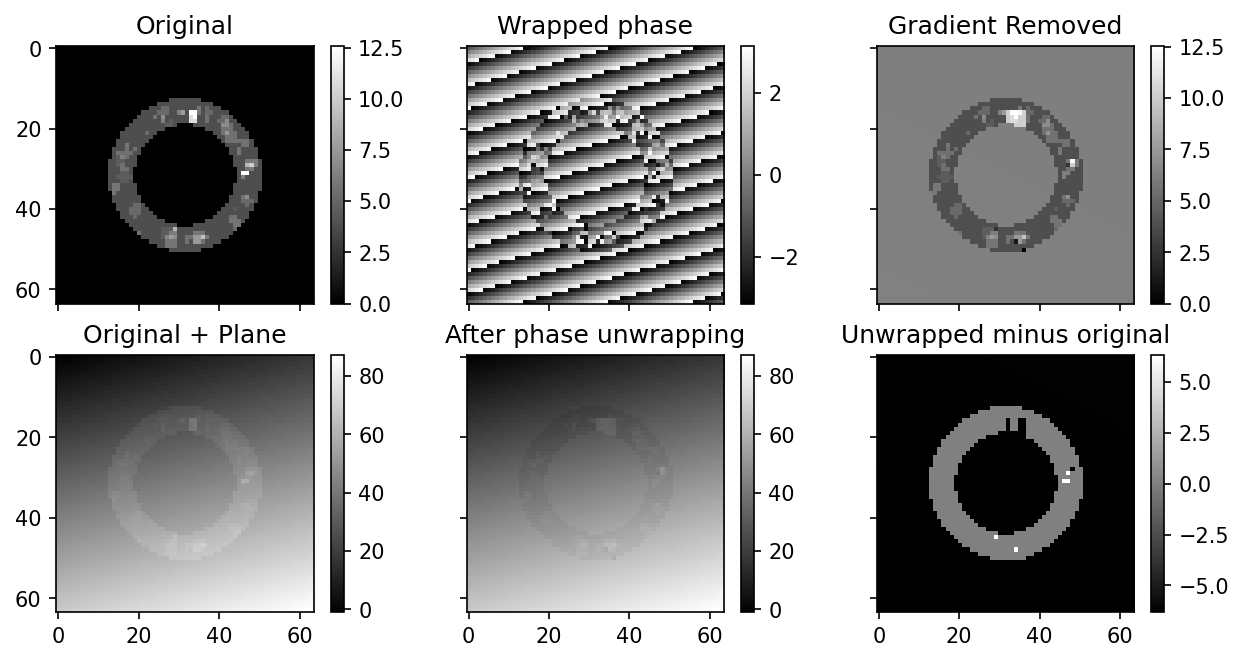

In [89]:
import numpy
def RemoveGrad_new( img, mask ):
    xy = numpy.argwhere( mask > 0)
    n = len(xy)
    y = xy[:,0].reshape([n,1])
    x = xy[:,1].reshape([n,1])
    F = numpy.array([ img[y[k],x[k]] for k in range(n) ]).reshape([n,1])
    mat = numpy.zeros([3,3])
    vec = numpy.zeros([3,1])
    mat[0,0] = (x*x).sum()
    mat[0,1] = (x*y).sum()
    mat[0,2] = (x).sum()
    mat[1,0] = mat[0,1]
    mat[1,1] = (y*y).sum()
    mat[1,2] = (y).sum()
    mat[2,0] = mat[0,2]
    mat[2,1] = mat[1,2]
    mat[2,2] = n
    vec[0,0] = (x*F).sum()
    vec[1,0] = (y*F).sum()
    vec[2,0] = (F).sum()
    eye = numpy.eye(mat.shape[0])
    eps = 1e-3 # valor tirado do *
    if 1: # com regularização
        abc = numpy.dot( numpy.linalg.inv(mat + eps * eye), vec).flatten() 
    else: # sem regularização
        abc = numpy.dot( numpy.linalg.inv(mat), vec).flatten()
    a = abc[0]
    b = abc[1]
    c = abc[2]
    new   = numpy.zeros(img.shape)
    row   = new.shape[0]
    col   = new.shape[1]
    XX,YY = numpy.meshgrid(numpy.arange(col),numpy.arange(row))
    new[y, x] = img[ y, x] - ( a*XX[y,x] + b*YY[y,x] + c )
    print('Fitted',a,b,c)
    #for k in range(n):
    #    new[y[k], x[k]] = img[ y[k], x[k]] - ( a*x[k] + b*y[k] + c )
    return new

# Load an image as a floating-point grayscale
image0 = img_as_float(img)
image0 = exposure.rescale_intensity(image0, out_range=(0, 4 * np.pi))
# image0 = np.exp(1j*image0)

x = np.linspace(0,image0.shape[0]-1,image0.shape[0])
X, Y = np.meshgrid(x,x)
a=0.3
b=1.1
c=-1
print('Real',a,b,c)
plane = a*X+b*Y +c
image = image0 + plane
# print(np.max(image), np.min(image))
# Scale the image to [0, 4*pi]

# image = exposure.rescale_intensity(image, out_range=(0, 50 * np.pi))
# image = exposure.rescale_intensity(image, out_range=(0, 4 * np.pi))
# Create a phase-wrapped image in the interval [-pi, pi)
image_wrapped = np.angle(np.exp(1j * image))
mask = np.zeros_like(image,dtype=bool)
mask[0:15,0:15] = True
# mask = ~mask
mask = np.ones_like(mask,dtype=bool)
# Perform phase unwrapping
image_grad_remove = RemoveGrad_new(image_wrapped,mask)

image_unwrapped = unwrap_phase(image_wrapped)
# image_unwrapped -= np.min(image_unwrapped)

image_grad_remove = RemoveGrad_new(image_unwrapped,mask)
image_grad_remove -= np.min(image_grad_remove)
fig, ax = plt.subplots(2, 3, dpi=150, figsize=(10,5),sharex=True, sharey=True)
ax1, ax2, ax3, ax4, ax5, ax6 = ax.ravel()
fig.colorbar(ax1.imshow(image0, cmap='gray'), ax=ax1)
ax1.set_title('Original')
fig.colorbar(ax4.imshow(image, cmap='gray'), ax=ax4)
ax4.set_title('Original + Plane')
fig.colorbar(ax3.imshow(image_grad_remove, cmap='gray'), ax=ax3)
ax3.set_title('Gradient Removed')
fig.colorbar(ax2.imshow(image_wrapped, cmap='gray', vmin=-np.pi, vmax=np.pi), ax=ax2)
ax2.set_title('Wrapped phase')
fig.colorbar(ax5.imshow(image_unwrapped, cmap='gray'), ax=ax5)
ax5.set_title('After phase unwrapping')
fig.colorbar(ax6.imshow(image0 - image_grad_remove, cmap='gray'), ax=ax6)
ax6.set_title('Unwrapped minus original')



(array([ 62, 130]), array([ 87, 105]))


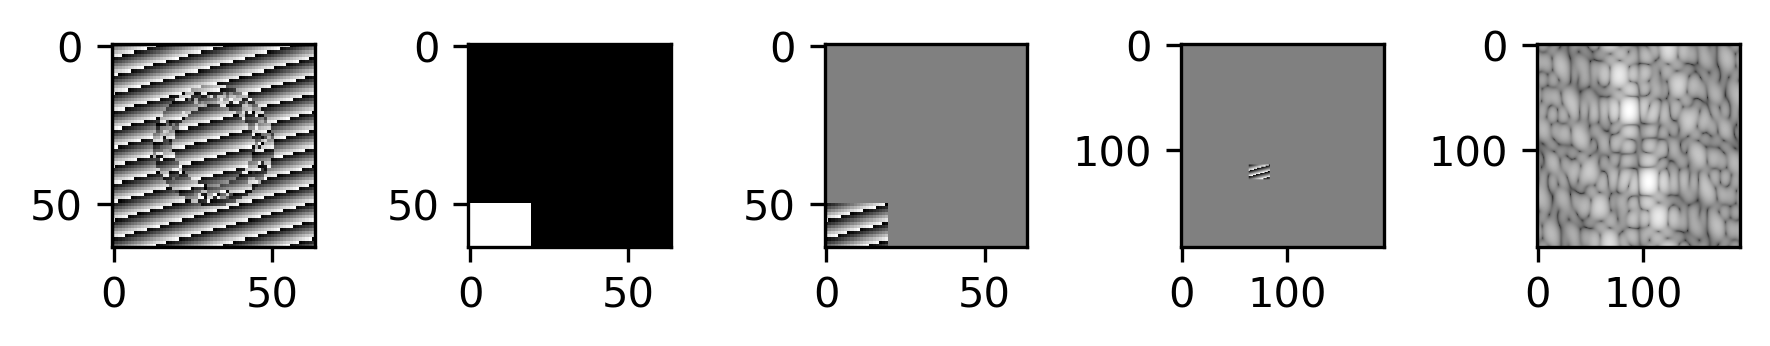

In [90]:
w_mask = np.zeros_like(image_wrapped)
w_mask[50:,:20] = 1

masked_image = image_wrapped*w_mask

size_y, size_x = image_wrapped.shape


from numpy.fft import fft2, fftshift, ifftshift, ifft2

padded_image = np.pad(masked_image,masked_image.shape[0])

FT = np.abs(fftshift(fft2(padded_image)))
maximumFT = np.where(FT == np.max(FT))
print(maximumFT)
# sigma2 = 2 - 2*FT

from matplotlib.colors import LogNorm
figure, ax = plt.subplots(1,5,dpi=300)
ax[0].imshow(image_wrapped,cmap='gray')
ax[1].imshow(w_mask,cmap='gray')
ax[2].imshow(masked_image, cmap='gray')
ax[3].imshow(padded_image,cmap='gray')
ax[4].imshow(FT,cmap='gray',norm=LogNorm())
figure.tight_layout()


(4096, 3)
[-0.00107669  0.00140911 -0.00039394]


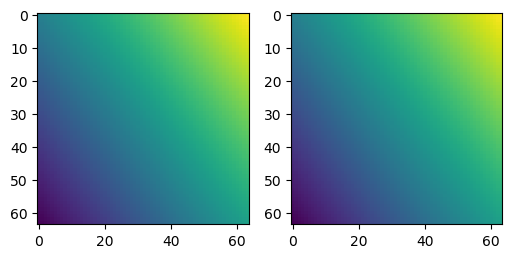

In [92]:
# idx = np.where(w_mask == True)
# maxy,miny = np.max(idx[0]), np.min(idx[0])
# maxx,minx = np.max(idx[1]), np.min(idx[1])
# non_null = image_wrapped[w_mask==1]
# non_null = np.reshape(non_null,(1+maxy-miny,1+maxx-minx))
# print(non_null.shape)
# size_y, size_x = non_null.shape
# masked_image = non_null

xx = np.linspace(0,size_x-1,size_x)
yy = np.linspace(0,size_y-1,size_y)
Ymesh, Xmesh = np.meshgrid(yy,xx)

matrix = np.zeros((3,Xmesh.flatten().shape[0]))
matrix[0,:] = Xmesh.flatten()/size_x
matrix[1,:] = Ymesh.flatten()/size_y
matrix[2,:] = np.ones_like(Xmesh.flatten().shape)

matrixT = matrix.T
print(matrixT.shape)
k=0
phi = masked_image.flatten()/(2*np.pi)-k
pseudoinverse = np.linalg.pinv(matrixT)
pseudoinverse.shape, phi.shape
v = pseudoinverse@phi
print(v)

plane = v[0]*Xmesh + v[1]*Ymesh + v[2]

figure, subplot = plt.subplots(1,2,dpi=100)
subplot[0].imshow(plane)
subplot[1].imshow(np.angle(np.exp(1j*plane)))


In [94]:
masked_image

array([[-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.        ,
        -0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-3.01503838, -2.71503838, -2.41503838, ...,  0.        ,
         0.        , -0.        ],
       [-1.91503838, -1.61503838, -1.31503838, ..., -0.        ,
        -0.        , -0.        ],
       [-0.81503838, -0.51503838, -0.21503838, ..., -0.        ,
        -0.        , -0.        ]])